In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
import pandas as pd
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizer
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification
from transformers import EarlyStoppingCallback

In [3]:
dataset = load_dataset("fancyzhx/yelp_polarity")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [4]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

In [4]:
train_df.head()

In [5]:
test_df.head()

,text,label
0,"Contrary to other reviews, I have zero complai...",1
1,Last summer I had an appointment to get new ti...,0
2,"Friendly staff, same starbucks fair you get an...",1
3,The food is good. Unfortunately the service is...,0
4,Even when we didn't have a car Filene's Baseme...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    560000 non-null  object
 1   label   560000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


In [7]:
train_df.isnull().sum()

,0
text,0
label,0


In [8]:
train_df.sample(5)['text'].values

array(["I really can't believe I'm giving Charlie Palmers 2 stars but here's why. \\n\\nI ate there twice in two years and both times my Bone In Ribeye had too much muscle in the steak.  I'm through.  I no doubt will stick to Mastro's, Ruth Chris or Joe's Stone Crab.\\n\\nService was right on but the food could be better and they need to add a bone in Filet for those who don't want the muscle and marbling (I like the marbling though).  \\n\\nTime to change the menu boys........",
       'bone marrow. get the bone marrow.',
       "They close earlier than most large book retailers, 10pm ... Major bummer for those who like to hit up a bookstore late at night instead if the club! Lol. It seems I usually can't find what I want at this particular location. It's in my area or I'd probably pass on it altogether. This review is location specific. I do love bookstores in general...",
       "Lousy return policy.  They have recently rolled out internet site.  Only a 15 day return!  Any mail orde

In [9]:
def clean_text(text):
    text = text.replace('\\n', ' ')
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\\"', '"')
    text = text.strip()
    return text
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [10]:
train_df.duplicated(subset='text').sum()

np.int64(49)

In [11]:
train_df = train_df.drop_duplicates(subset='text').reset_index(drop=True)

In [12]:
train_df.duplicated(subset='text').sum()

np.int64(0)

In [13]:
test_df.duplicated(subset='text').sum()

np.int64(0)

In [14]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [15]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = dataset['test']

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=256)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [17]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/503955 [00:00<?, ? examples/s]

Map:   0%|          | 0/55996 [00:00<?, ? examples/s]

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [18]:
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val = tokenized_val.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

In [19]:
tokenized_traintokenized_train = tokenized_train.remove_columns(["text"])
tokenized_val = tokenized_val.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

In [20]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
!pip install -U transformers

In [22]:
import transformers
print(transformers.__version__)
print(transformers.TrainingArguments.__init__.__code__.co_varnames)

4.51.3
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_ba

In [23]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    disable_tqdm=False,
    report_to="none"
)

In [24]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

In [25]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00


In [26]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')
    precision_score = precision.compute(predictions=predictions, references=labels, average='weighted')
    recall_score = recall.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': acc['accuracy'],
        'f1': f1_score['f1'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall']
    }


Training

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(5000)),
    eval_dataset=test_dataset.select(range(1000)),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.199190,0.928000,0.927967,0.928120,0.928000
2,0.243400,0.229946,0.929000,0.929017,0.929185,0.929000
3,0.243400,0.286207,0.935000,0.934941,0.935425,0.935000
4,0.072000,0.331801,0.944000,0.943974,0.944138,0.944000
5,0.017400,0.352874,0.941000,0.941002,0.941006,0.941000
6,0.017400,0.364365,0.941000,0.941006,0.941029,0.941000


TrainOutput(global_step=1878, training_loss=0.08946032150865743, metrics={'train_runtime': 762.857, 'train_samples_per_second': 39.326, 'train_steps_per_second': 2.462, 'total_flos': 3946665830400000.0, 'train_loss': 0.08946032150865743, 'epoch': 6.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.33180108666419983,
 'eval_accuracy': 0.944,
 'eval_f1': 0.9439741853762562,
 'eval_precision': 0.9441377118644068,
 'eval_recall': 0.944,
 'eval_runtime': 7.1459,
 'eval_samples_per_second': 139.941,
 'eval_steps_per_second': 2.239,
 'epoch': 6.0}

**Visualization**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


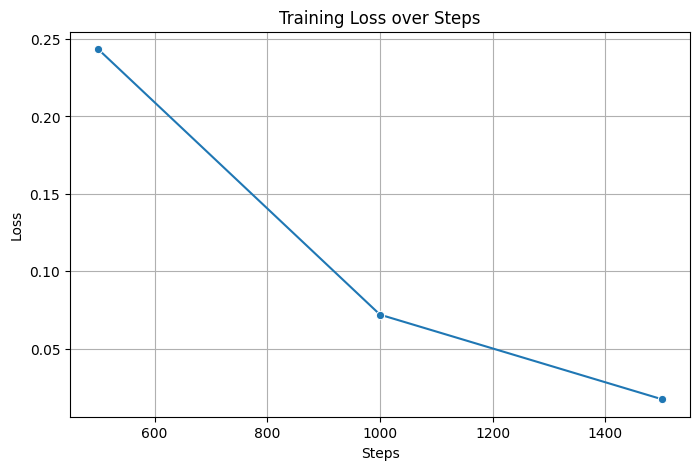

In [ ]:
history = trainer.state.log_history

logs_df = pd.DataFrame(trainer.state.log_history)
logs_df.head()

# Filter loss values only
train_loss_df = logs_df.dropna(subset=['loss'])

plt.figure(figsize=(8, 5))
sns.lineplot(x='step', y='loss', data=train_loss_df, marker="o")
plt.title("Training Loss over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


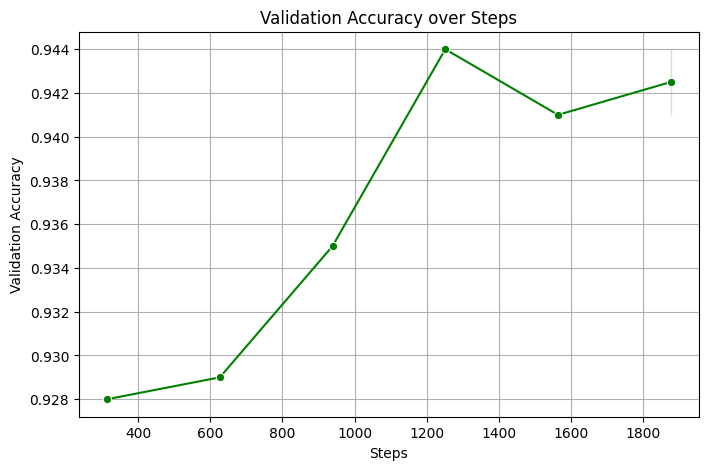

In [ ]:
# Filter eval accuracy values only
eval_acc_df = logs_df.dropna(subset=['eval_accuracy'])

plt.figure(figsize=(8, 5))
sns.lineplot(x='step', y='eval_accuracy', data=eval_acc_df, marker="o", color="green")
plt.title("Validation Accuracy over Steps")
plt.xlabel("Steps")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

**Save Fine-tuned Model**

In [ ]:
model.save_pretrained("./my_finetuned_model")
tokenizer.save_pretrained("./my_finetuned_model")

('./my_finetuned_model/tokenizer_config.json',
 './my_finetuned_model/special_tokens_map.json',
 './my_finetuned_model/vocab.txt',
 './my_finetuned_model/added_tokens.json',
 './my_finetuned_model/tokenizer.json')

**Deployment**

In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=-1).item()

    if prediction == 1:
        return "Positive 👍"
    else:
        return "Negative 👎"

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Type a Yelp review here..."),
    outputs="text",
    title="Yelp Review Sentiment Classifier",
    description="Enter a review and I'll tell you if it's Positive or Negative!"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://6722a6744ab8ffac35.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
